In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

In [3]:
def load_data(file_path):
    """Load the diabetic readmission dataset"""
    try:
        df = pd.read_csv(file_path)
        print("Data loaded successfully.")
        print(f"Dataset shape: {df.shape}")
        return df
    except FileNotFoundError:
        print(f"File not found: {file_path}")
        return None

# Load the data
data_path = "/Users/hassanali/Desktop/USD/AAI-510/Final Project/Dataset/diabetic_data.csv"
df = load_data(data_path)


Data loaded successfully.
Dataset shape: (101766, 50)


In [4]:
def basic_info(df):
    """Display basic information about the dataset"""
    print("\n" + "="*50)
    print("DATASET OVERVIEW")
    print("="*50)
    print(f"Number of rows: {df.shape[0]:,}")
    print(f"Number of columns: {df.shape[1]:,}")
    print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    
    print("\nCOLUMN DATA TYPES:")
    print(df.dtypes.value_counts())
    
    print("\nFIRST 5 ROWS:")
    print(df.head())
    
    print("\nBASIC STATISTICS:")
    print(df.describe())

# Run basic info analysis
if df is not None:
   basic_info(df)


DATASET OVERVIEW
Number of rows: 101,766
Number of columns: 50
Memory usage: 220.22 MB

COLUMN DATA TYPES:
object    37
int64     13
Name: count, dtype: int64

FIRST 5 ROWS:
   encounter_id  patient_nbr             race  gender      age weight  \
0       2278392      8222157        Caucasian  Female   [0-10)      ?   
1        149190     55629189        Caucasian  Female  [10-20)      ?   
2         64410     86047875  AfricanAmerican  Female  [20-30)      ?   
3        500364     82442376        Caucasian    Male  [30-40)      ?   
4         16680     42519267        Caucasian    Male  [40-50)      ?   

   admission_type_id  discharge_disposition_id  admission_source_id  \
0                  6                        25                    1   
1                  1                         1                    7   
2                  1                         1                    7   
3                  1                         1                    7   
4                  1           


MISSING VALUES ANALYSIS
Missing Values Summary:
           Column  Missing_Count  Missing_Percentage
22  max_glu_serum          96420           94.746772
23      A1Cresult          84748           83.277322

CHECKING FOR '?' VALUES (treated as missing):
Columns with '?' values:
  weight: 98,569 (96.86%)
  medical_specialty: 49,949 (49.08%)
  payer_code: 40,256 (39.56%)
  race: 2,273 (2.23%)
  diag_3: 1,423 (1.40%)
  diag_2: 358 (0.35%)
  diag_1: 21 (0.02%)


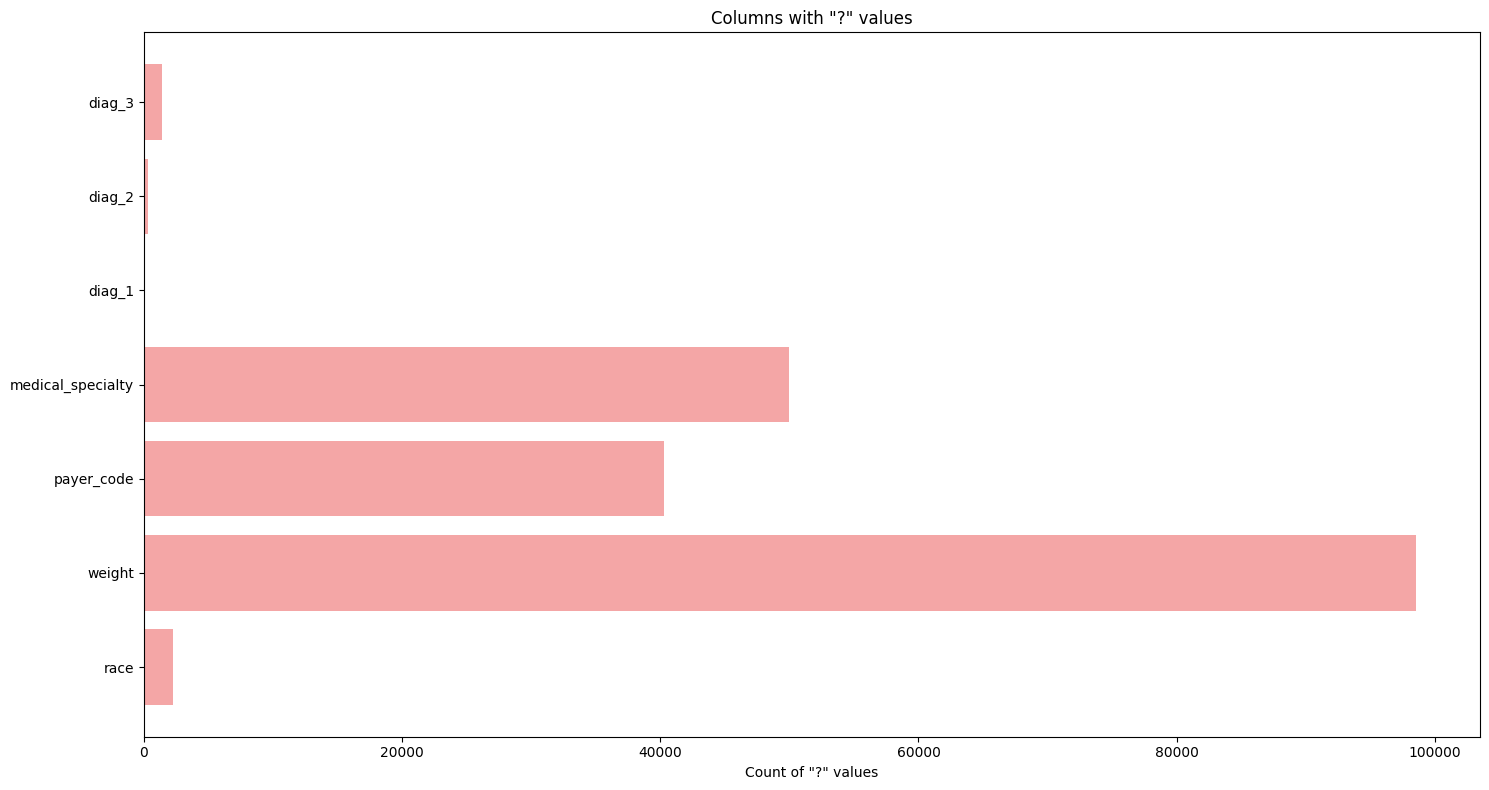

In [5]:
# =====================================
# 2. MISSING VALUES ANALYSIS
# =====================================

def analyze_missing_values(df):
    """Comprehensive missing values analysis"""
    print("\n" + "="*50)
    print("MISSING VALUES ANALYSIS")
    print("="*50)
    
    # Calculate missing values
    missing_data = df.isnull().sum()
    missing_percent = 100 * missing_data / len(df)
    
    # Create missing values summary
    missing_summary = pd.DataFrame({
        'Column': missing_data.index,
        'Missing_Count': missing_data.values,
        'Missing_Percentage': missing_percent.values
    })
    missing_summary = missing_summary[missing_summary['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False)
    
    print("Missing Values Summary:")
    print(missing_summary)
    
    # Handle '?' as missing values (common in this dataset)
    print("\nCHECKING FOR '?' VALUES (treated as missing):")
    question_mark_counts = {}
    for col in df.columns:
        if df[col].dtype == 'object':
            count = (df[col] == '?').sum()
            if count > 0:
                question_mark_counts[col] = count
    
    if question_mark_counts:
        print("Columns with '?' values:")
        for col, count in sorted(question_mark_counts.items(), key=lambda x: x[1], reverse=True):
            percentage = (count / len(df)) * 100
            print(f"  {col}: {count:,} ({percentage:.2f}%)")
    
    # Visualization of missing values
    if question_mark_counts:
        plt.figure(figsize=(15, 8))
        
        # Plot: '?' values visualization
        cols = list(question_mark_counts.keys())
        counts = [question_mark_counts[col] for col in cols]
        
        plt.barh(cols, counts, color='lightcoral', alpha=0.7)
        plt.xlabel('Count of "?" values')
        plt.title('Columns with "?" values')
        plt.tight_layout()
        plt.show()
    
    return missing_summary, question_mark_counts

# Run missing values analysis
if df is not None:
    missing_summary, question_counts = analyze_missing_values(df)


TARGET VARIABLE ANALYSIS
Original Target Variable Distribution:
  NO: 54,864 (53.91%)
  >30: 35,545 (34.93%)
  <30: 11,357 (11.16%)

Binary Target Variable Distribution (Focus: <30 days):
  0 (NO or >30): 90,409 (88.84%)
  1 (<30): 11,357 (11.16%)


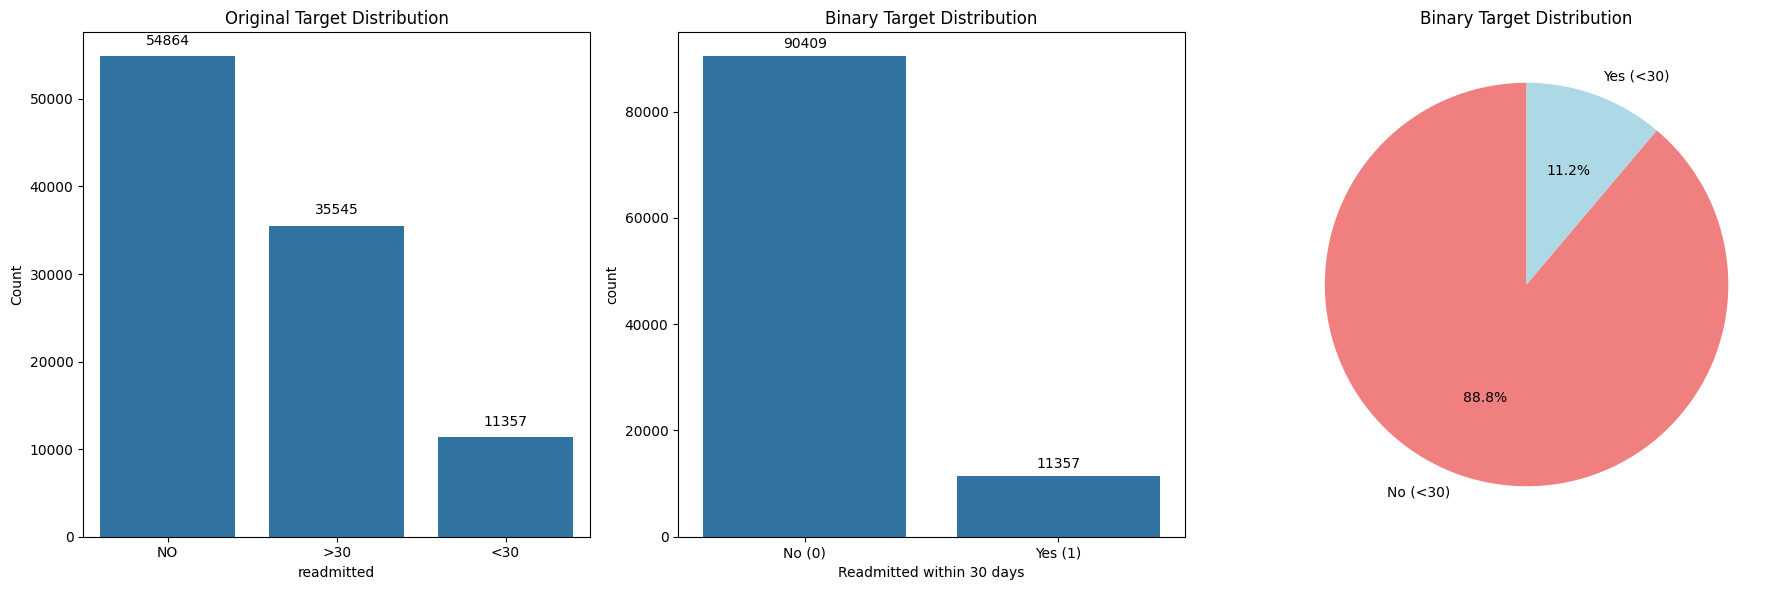


CLASS IMBALANCE CHECK (Binary Target):
Majority class percentage: 88.84%
Minority class percentage: 11.16%
Imbalance ratio: 7.96
  Severe class imbalance - Grp1 will consider using SMOTE, KMEANS-SMOTE, or ADASYN for balancing.


In [6]:
# =====================================
# 3. TARGET VARIABLE ANALYSIS
# =====================================

def analyze_target_variable(df, target_col='readmitted'):
    """Analyze the target variable distribution"""
    print("\n" + "="*50)
    print("TARGET VARIABLE ANALYSIS")
    print("="*50)
    
    # Original target variable distribution
    target_counts = df[target_col].value_counts()
    target_percentages = df[target_col].value_counts(normalize=True) * 100
    
    print("Original Target Variable Distribution:")
    for value in target_counts.index:
        print(f"  {value}: {target_counts[value]:,} ({target_percentages[value]:.2f}%)")
    
    # Create binary target: 1 for <30 (readmitted within 30 days), 0 for others
    df['readmitted_binary'] = (df[target_col] == '<30').astype(int)
    
    # Binary target distribution
    binary_counts = df['readmitted_binary'].value_counts()
    binary_percentages = df['readmitted_binary'].value_counts(normalize=True) * 100
    
    print("\nBinary Target Variable Distribution (Focus: <30 days):")
    print(f"  0 (NO or >30): {binary_counts[0]:,} ({binary_percentages[0]:.2f}%)")
    print(f"  1 (<30): {binary_counts[1]:,} ({binary_percentages[1]:.2f}%)")
    
    # Visualization
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Original distribution
    sns.countplot(data=df, x=target_col, ax=axes[0])
    axes[0].set_title('Original Target Distribution')
    axes[0].set_ylabel('Count')
    for i, v in enumerate(target_counts.values):
        axes[0].text(i, v + 1000, str(v), ha='center', va='bottom')
    
    # Binary distribution
    sns.countplot(data=df, x='readmitted_binary', ax=axes[1])
    axes[1].set_title('Binary Target Distribution')
    axes[1].set_xlabel('Readmitted within 30 days')
    axes[1].set_xticklabels(['No (0)', 'Yes (1)'])
    for i, v in enumerate(binary_counts.values):
        axes[1].text(i, v + 1000, str(v), ha='center', va='bottom')
    
    # Pie chart for binary
    axes[2].pie(binary_counts.values, labels=['No (<30)', 'Yes (<30)'], 
               autopct='%1.1f%%', startangle=90, colors=['lightcoral', 'lightblue'])
    axes[2].set_title('Binary Target Distribution')
    
    plt.tight_layout()
    plt.show()
    
    # Class imbalance check for binary target
    print(f"\nCLASS IMBALANCE CHECK (Binary Target):")
    print(f"Majority class percentage: {binary_percentages.max():.2f}%")
    print(f"Minority class percentage: {binary_percentages.min():.2f}%")
    imbalance_ratio = binary_percentages.max() / binary_percentages.min()
    print(f"Imbalance ratio: {imbalance_ratio:.2f}")
    
    if imbalance_ratio > 5:
        print("  Severe class imbalance - Grp1 will consider using SMOTE, KMEANS-SMOTE, or ADASYN for balancing.")
    elif imbalance_ratio > 2:
        print("  Moderate class imbalance - Grp1 will consider using SMOTE, KMEANS-SMOTE, or ADASYN for balancing.")
    
    return target_counts, binary_counts

# Run target variable analysis
if df is not None:
    target_analysis, binary_analysis = analyze_target_variable(df)


NUMERICAL VARIABLES ANALYSIS
Numerical columns (9): ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses', 'readmitted_binary']

Statistical Summary:
       time_in_hospital  num_lab_procedures  num_procedures  num_medications  \
count         101766.00           101766.00       101766.00        101766.00   
mean               4.40               43.10            1.34            16.02   
std                2.99               19.67            1.71             8.13   
min                1.00                1.00            0.00             1.00   
25%                2.00               31.00            0.00            10.00   
50%                4.00               44.00            1.00            15.00   
75%                6.00               57.00            2.00            20.00   
max               14.00              132.00            6.00            81.00   

       number_outpatie

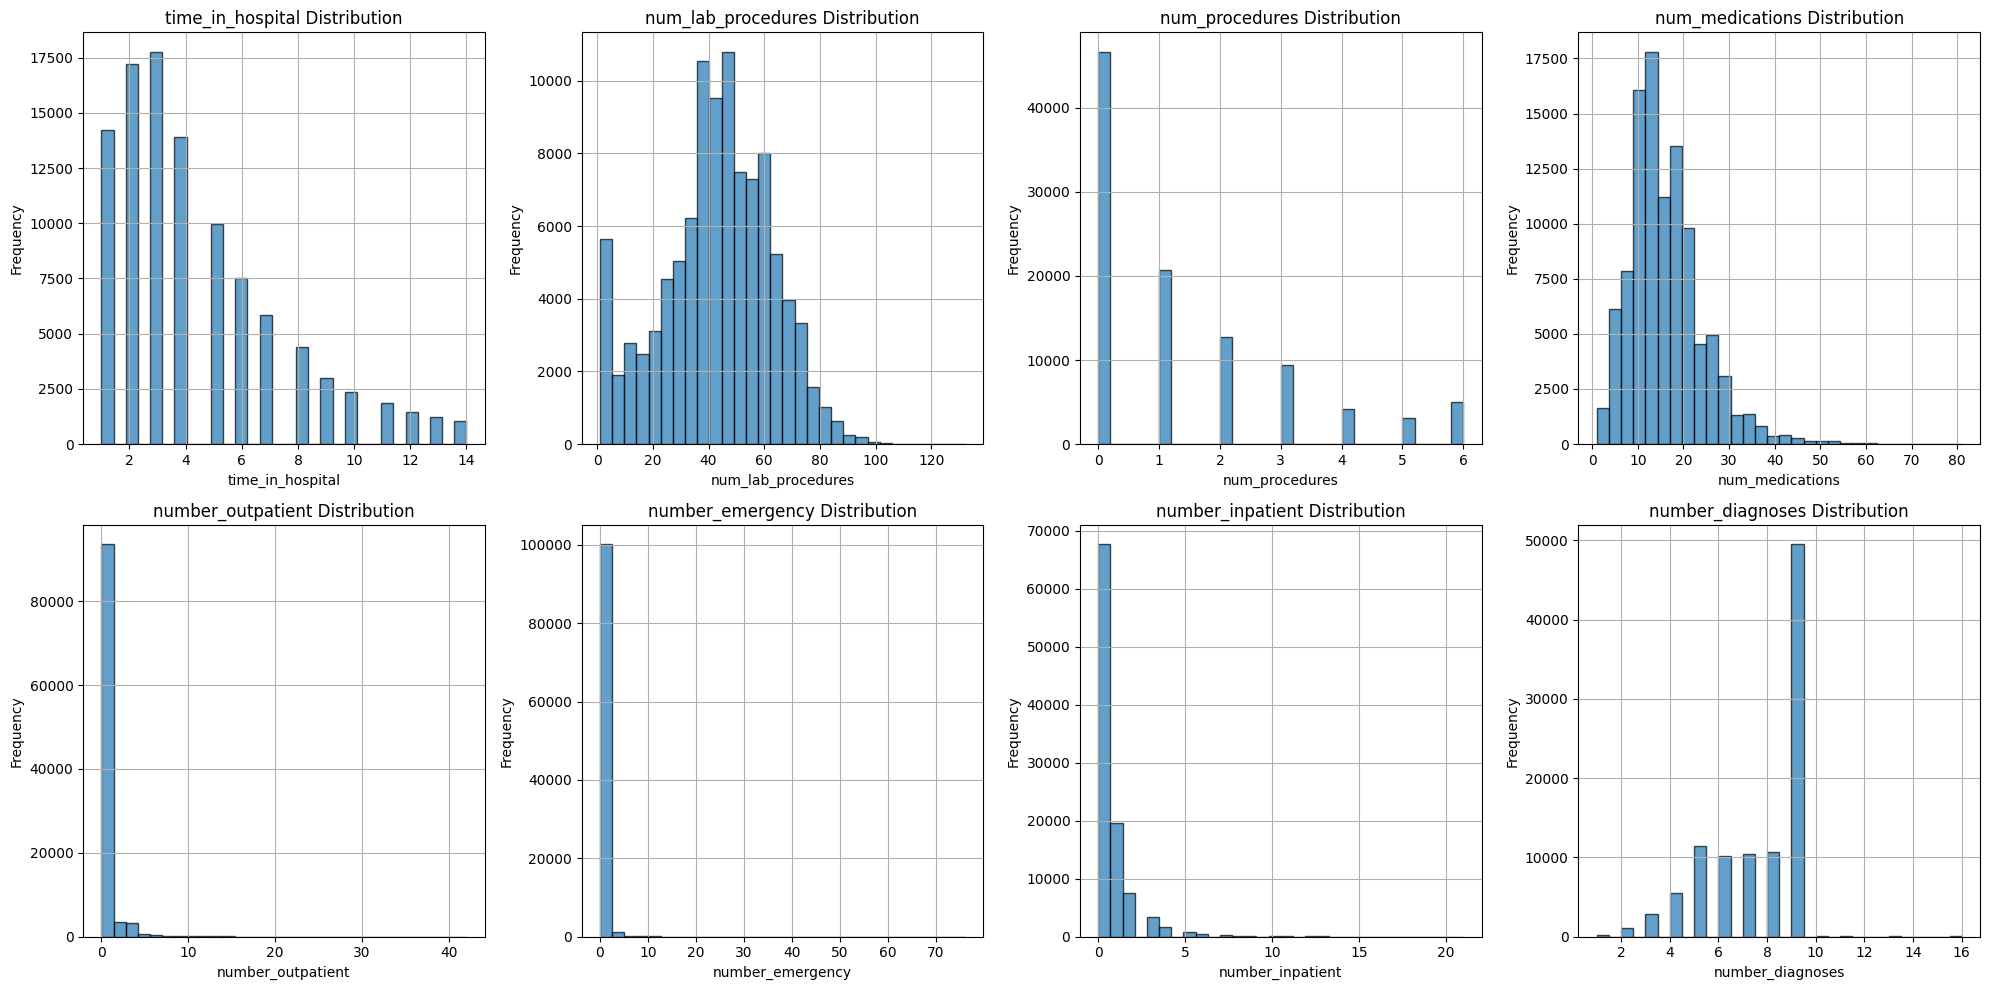

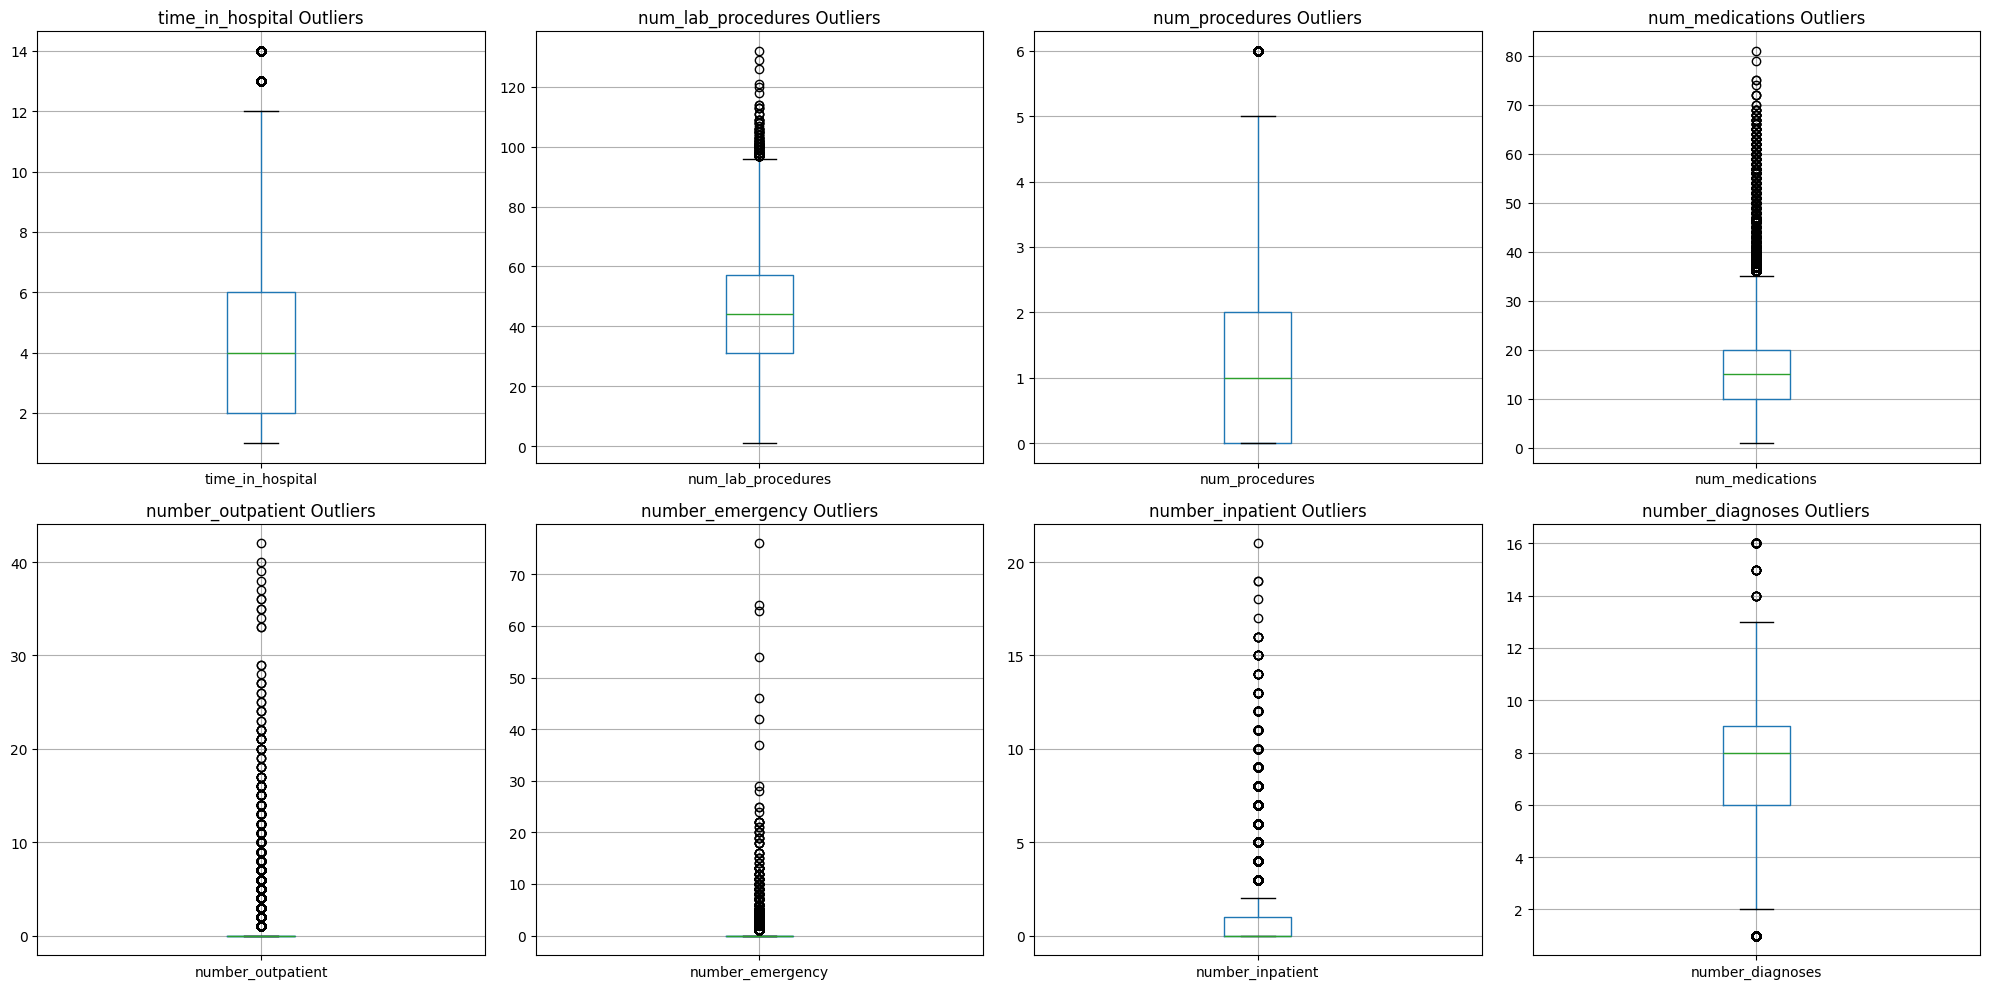

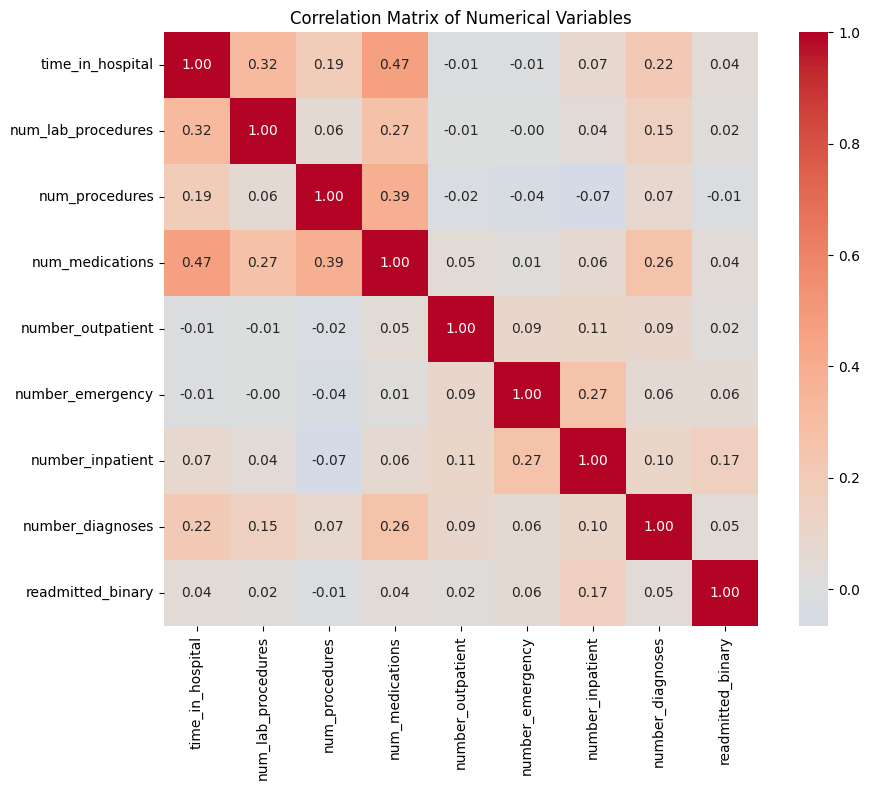

In [7]:
# =====================================
# 4. NUMERICAL VARIABLES ANALYSIS
# =====================================

def analyze_numerical_variables(df):
    """Analyze numerical variables for modeling insights"""
    print("\n" + "="*50)
    print("NUMERICAL VARIABLES ANALYSIS")
    print("="*50)
    
    # Identify numerical columns (exclude ID columns)
    numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    numerical_cols = [col for col in numerical_cols if 'id' not in col.lower() and 'nbr' not in col.lower()]
    
    print(f"Numerical columns ({len(numerical_cols)}): {numerical_cols}")
    
    # Statistical summary
    print("\nStatistical Summary:")
    print(df[numerical_cols].describe().round(2))
    
    # Distribution plots
    n_cols = len(numerical_cols)
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.ravel()
    
    for i, col in enumerate(numerical_cols):
        if i < len(axes):
            df[col].hist(bins=30, ax=axes[i], alpha=0.7, edgecolor='black')
            axes[i].set_title(f'{col} Distribution')
            axes[i].set_xlabel(col)
            axes[i].set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()
    
    # Box plots for outlier detection
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.ravel()
    
    for i, col in enumerate(numerical_cols):
        if i < len(axes):
            df.boxplot(column=col, ax=axes[i])
            axes[i].set_title(f'{col} Outliers')
    
    plt.tight_layout()
    plt.show()
    
    # Correlation matrix
    plt.figure(figsize=(10, 8))
    correlation_matrix = df[numerical_cols].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
                square=True, fmt='.2f')
    plt.title('Correlation Matrix of Numerical Variables')
    plt.tight_layout()
    plt.show()
    
    return numerical_cols

# Run numerical analysis
if df is not None:
    numerical_features = analyze_numerical_variables(df)


CATEGORICAL VARIABLES ANALYSIS
Categorical columns (36): ['race', 'gender', 'age', 'weight', 'payer_code', 'medical_specialty', 'diag_1', 'diag_2', 'diag_3', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed']


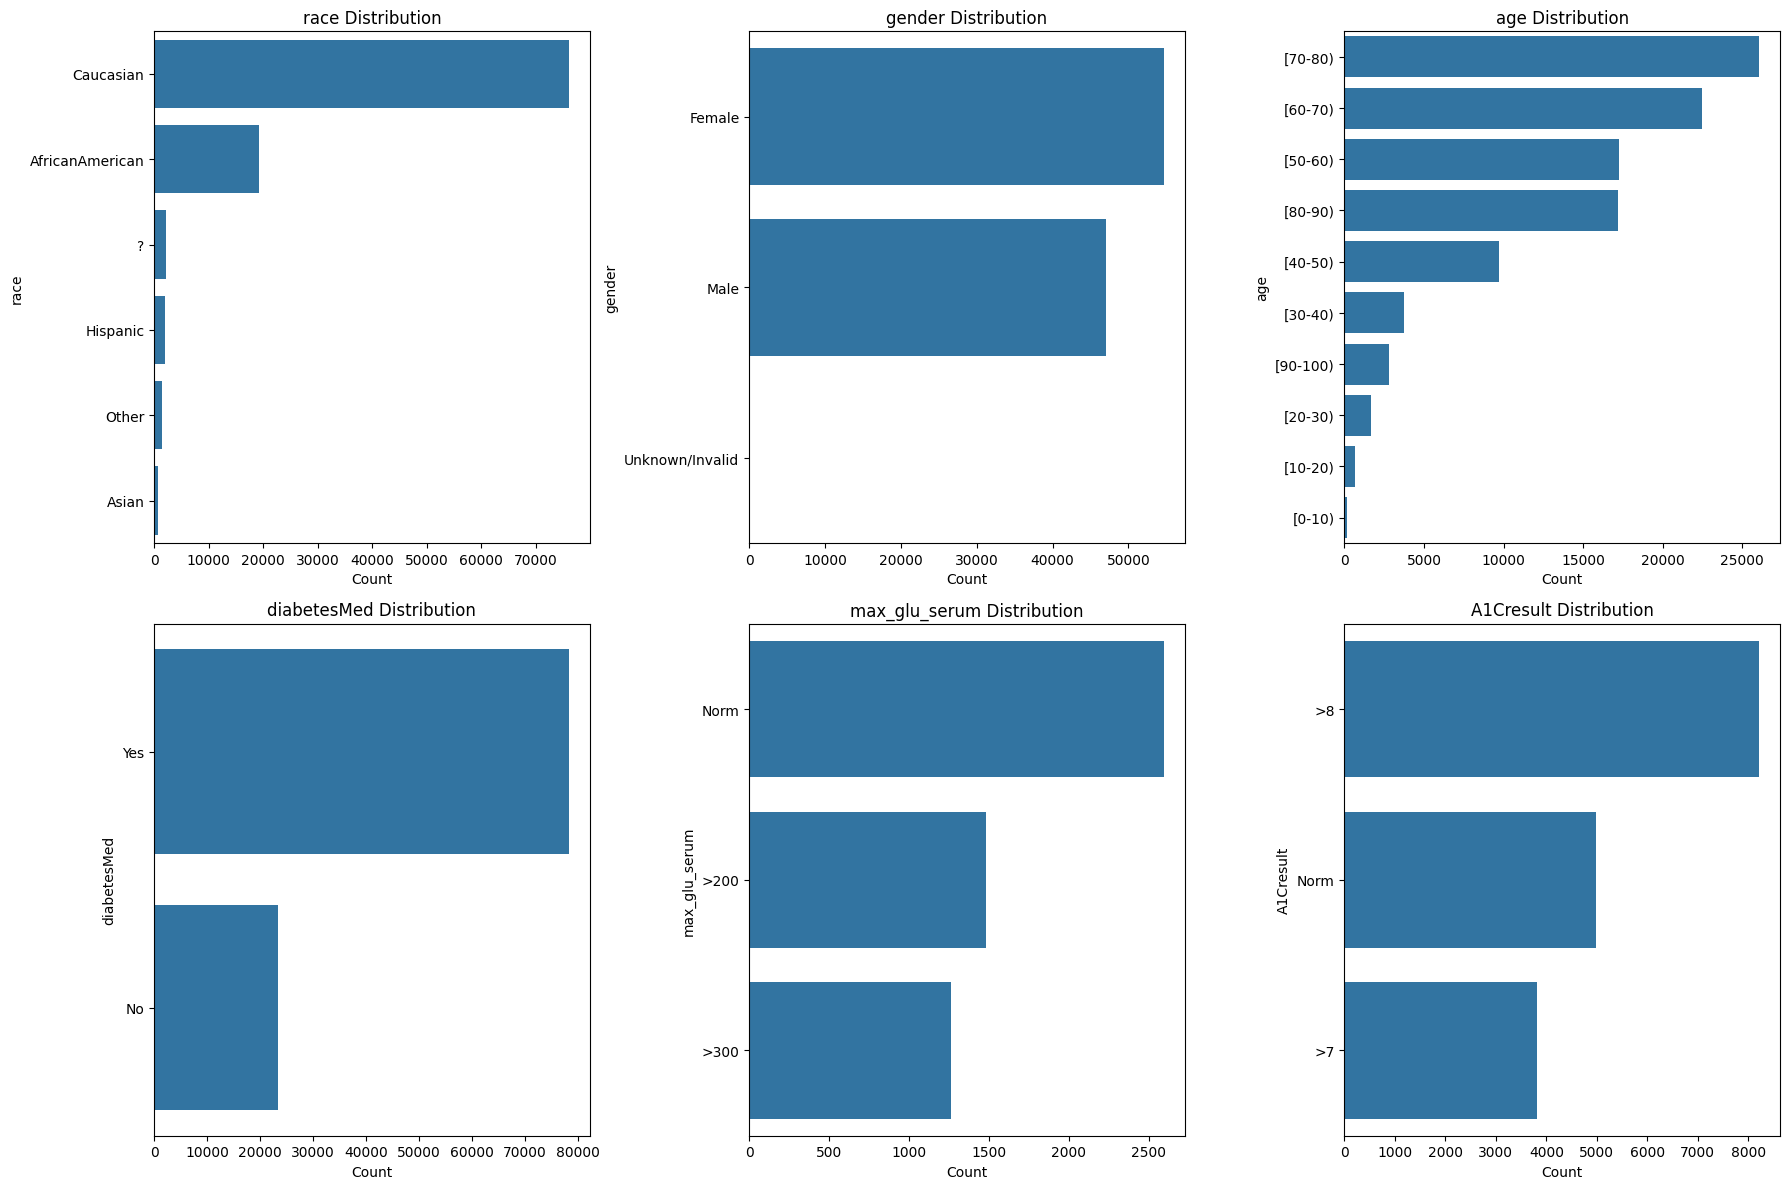

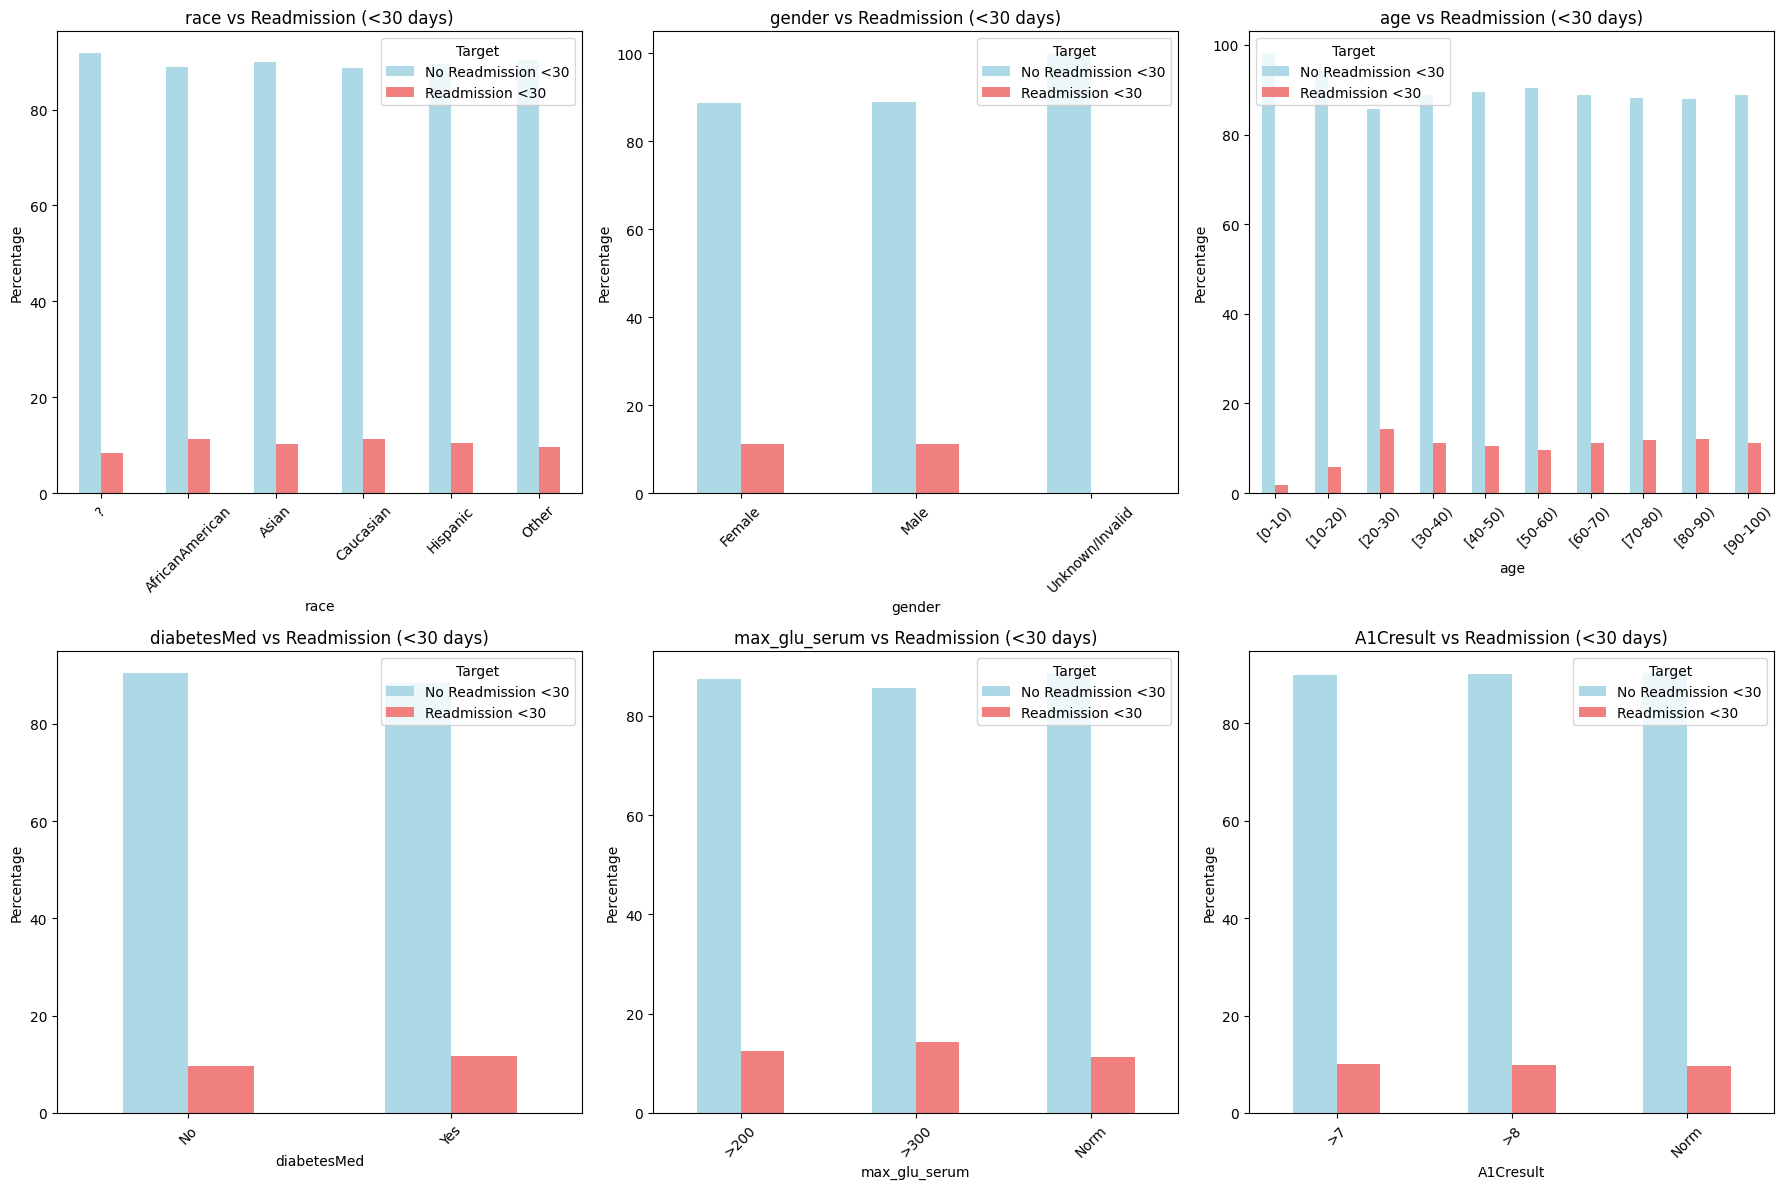


UNIQUE VALUES IN KEY CATEGORICAL COLUMNS:
  race: 6 unique values
    Values: ['Caucasian', 'AfricanAmerican', '?', 'Other', 'Asian', 'Hispanic']
  gender: 3 unique values
    Values: ['Female', 'Male', 'Unknown/Invalid']
  age: 10 unique values
    Values: ['[0-10)', '[10-20)', '[20-30)', '[30-40)', '[40-50)', '[50-60)', '[60-70)', '[70-80)', '[80-90)', '[90-100)']
  diabetesMed: 2 unique values
    Values: ['No', 'Yes']
  max_glu_serum: 3 unique values
    Values: [nan, '>300', 'Norm', '>200']
  A1Cresult: 3 unique values
    Values: [nan, '>7', '>8', 'Norm']


In [8]:
# =====================================
# 5. CATEGORICAL VARIABLES ANALYSIS
# =====================================

def analyze_categorical_variables(df, target_col='readmitted_binary'):
    """Analyze categorical variables for modeling insights"""
    print("\n" + "="*50)
    print("CATEGORICAL VARIABLES ANALYSIS")
    print("="*50)
    
    # Identify categorical columns (exclude target)
    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
    categorical_cols = [col for col in categorical_cols if col not in ['readmitted', target_col]]
    
    print(f"Categorical columns ({len(categorical_cols)}): {categorical_cols}")
    
    # Analyze key categorical variables for modeling
    key_categorical = ['race', 'gender', 'age', 'diabetesMed', 'max_glu_serum', 'A1Cresult']
    
    # Distribution plots
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.ravel()
    
    for i, col in enumerate(key_categorical):
        if col in df.columns and i < len(axes):
            value_counts = df[col].value_counts()
            
            if len(value_counts) <= 15:  # Only plot if not too many categories
                sns.countplot(data=df, y=col, ax=axes[i], order=value_counts.index[:10])
                axes[i].set_title(f'{col} Distribution')
                axes[i].set_xlabel('Count')
            else:
                # For columns with many categories, show top 10
                top_values = value_counts.head(10)
                axes[i].barh(range(len(top_values)), top_values.values)
                axes[i].set_yticks(range(len(top_values)))
                axes[i].set_yticklabels(top_values.index)
                axes[i].set_title(f'{col} Distribution (Top 10)')
                axes[i].set_xlabel('Count')
    
    plt.tight_layout()
    plt.show()
    
    # Relationship with BINARY target variable (<30 days readmission)
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.ravel()
    
    for i, col in enumerate(key_categorical):
        if col in df.columns and i < len(axes):
            # Create crosstab showing readmission rates by category (binary)
            crosstab = pd.crosstab(df[col], df[target_col], normalize='index') * 100
            crosstab.plot(kind='bar', ax=axes[i], 
                         color=['lightblue', 'lightcoral'])
            axes[i].set_title(f'{col} vs Readmission (<30 days)')
            axes[i].set_xlabel(col)
            axes[i].set_ylabel('Percentage')
            axes[i].legend(['No Readmission <30', 'Readmission <30'], title='Target')
            axes[i].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Print unique values for modeling consideration
    print("\nUNIQUE VALUES IN KEY CATEGORICAL COLUMNS:")
    for col in key_categorical:
        if col in df.columns:
            unique_count = df[col].nunique()
            print(f"  {col}: {unique_count} unique values")
            if unique_count <= 10:
                print(f"    Values: {df[col].unique().tolist()}")
    
    return categorical_cols

# Run categorical analysis
if df is not None:
    categorical_features = analyze_categorical_variables(df)


MEDICATION ANALYSIS
Top Medication Usage (patients who received each medication):
  insulin: 54,383 patients (53.44%)
  metformin: 19,988 patients (19.64%)
  glipizide: 12,686 patients (12.47%)
  glyburide: 10,650 patients (10.47%)
  pioglitazone: 7,328 patients (7.20%)
  rosiglitazone: 6,365 patients (6.25%)
  glimepiride: 5,191 patients (5.10%)
  repaglinide: 1,539 patients (1.51%)

Medication Impact on <30 Day Readmission:
  insulin: Used 12.1% vs Not Used 10.0% (Diff: +2.1%)
  metformin: Used 9.7% vs Not Used 11.5% (Diff: -1.8%)
  glipizide: Used 11.4% vs Not Used 11.1% (Diff: +0.3%)
  glyburide: Used 10.6% vs Not Used 11.2% (Diff: -0.6%)
  pioglitazone: Used 10.6% vs Not Used 11.2% (Diff: -0.6%)
  rosiglitazone: Used 10.4% vs Not Used 11.2% (Diff: -0.8%)
  glimepiride: Used 10.2% vs Not Used 11.2% (Diff: -1.0%)
  repaglinide: Used 13.3% vs Not Used 11.1% (Diff: +2.2%)


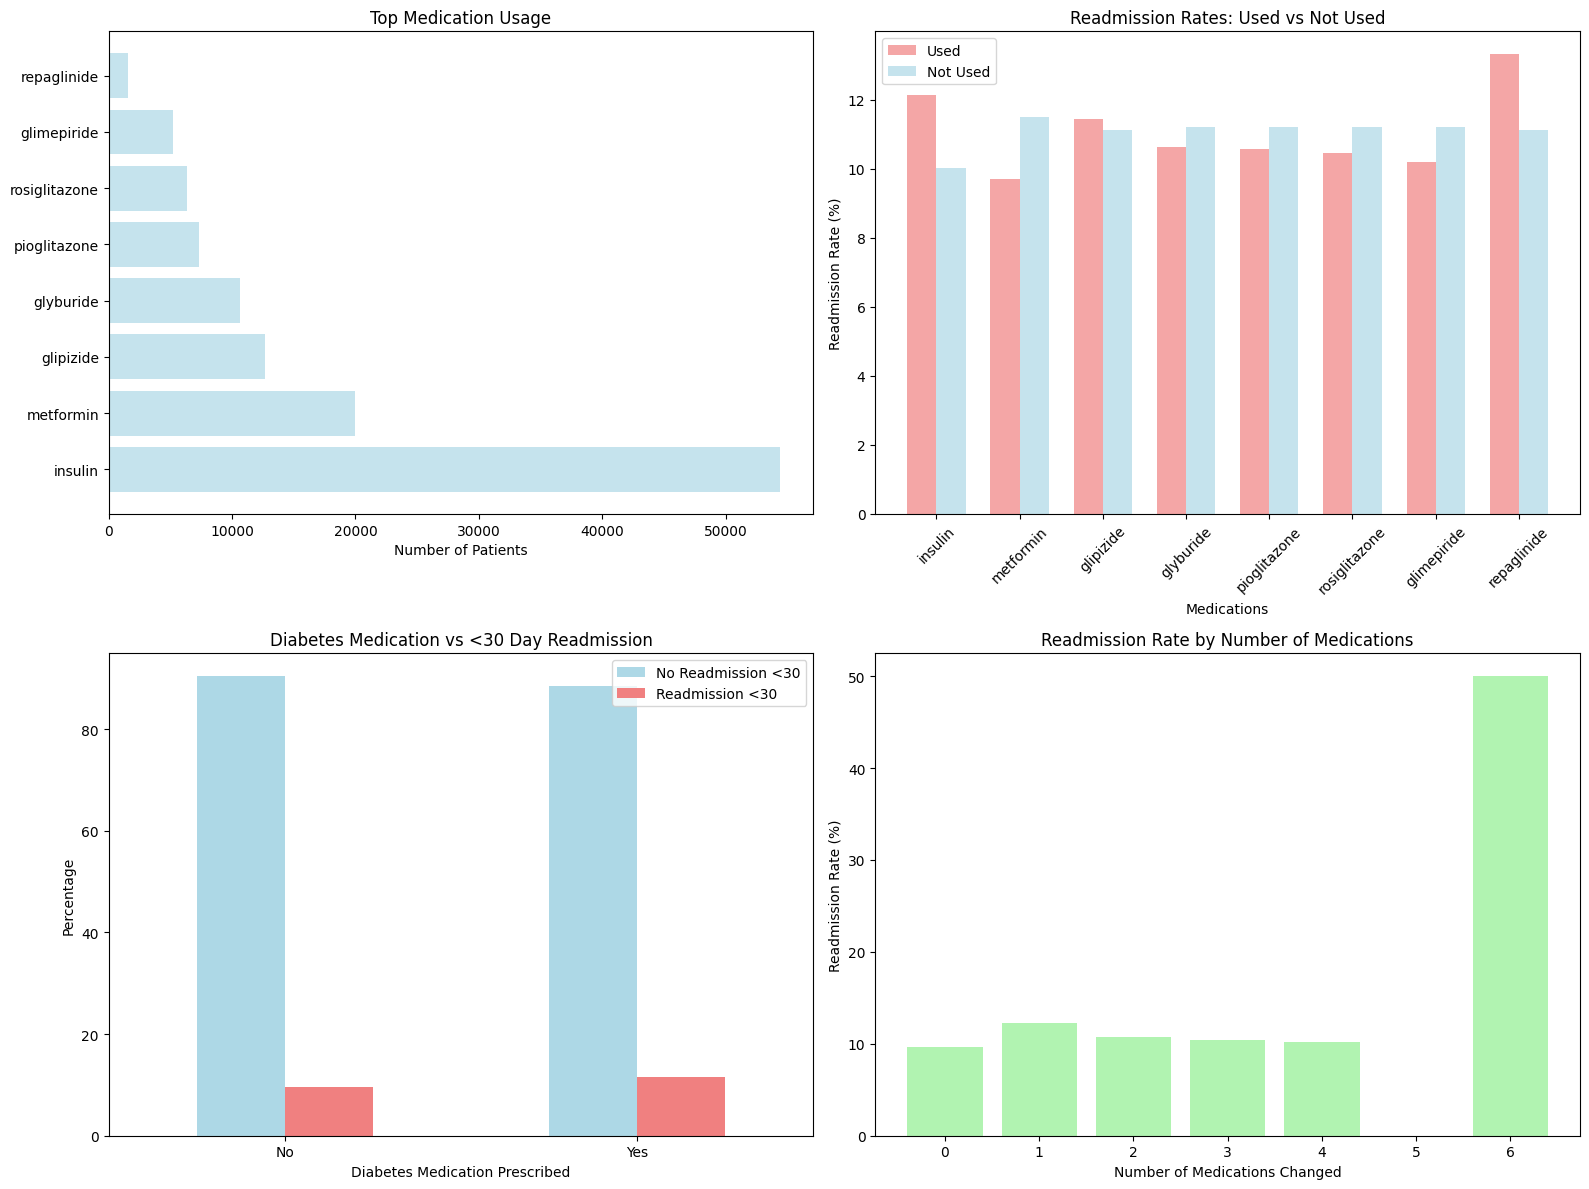

In [9]:
# =====================================
# 6. MEDICATION ANALYSIS
# =====================================

def analyze_medications(df, target_col='readmitted_binary'):
    """Analyze diabetes medications for modeling insights"""
    print("\n" + "="*50)
    print("MEDICATION ANALYSIS")
    print("="*50)
    
    # Identify medication columns
    medication_cols = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
                       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide',
                       'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
                       'miglitol', 'troglitazone', 'tolazamide', 'examide',
                       'citoglipton', 'insulin']
    
    # Count medication usage (any change from 'No')
    medication_usage = {}
    for med in medication_cols:
        if med in df.columns:
            usage_count = (df[med] != 'No').sum()
            medication_usage[med] = usage_count
    
    # Sort by usage and filter medications with reasonable usage
    sorted_meds = sorted(medication_usage.items(), key=lambda x: x[1], reverse=True)
    top_meds = [(med, count) for med, count in sorted_meds if count > 1000]  # At least 1000 patients
    
    print("Top Medication Usage (patients who received each medication):")
    for med, count in top_meds:
        percentage = (count / len(df)) * 100
        print(f"  {med}: {count:,} patients ({percentage:.2f}%)")
    
    # Medication vs readmission analysis
    print(f"\nMedication Impact on <30 Day Readmission:")
    med_impact = []
    for med, count in top_meds:
        # Calculate readmission rates
        med_used = df[df[med] != 'No'][target_col].mean() * 100
        med_not_used = df[df[med] == 'No'][target_col].mean() * 100
        difference = med_used - med_not_used
        
        med_impact.append((med, med_used, med_not_used, difference))
        print(f"  {med}: Used {med_used:.1f}% vs Not Used {med_not_used:.1f}% (Diff: {difference:+.1f}%)")
    
    # Visualizations
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Top medication usage
    meds, counts = zip(*top_meds[:8])  # Top 8
    axes[0,0].barh(meds, counts, color='lightblue', alpha=0.7)
    axes[0,0].set_xlabel('Number of Patients')
    axes[0,0].set_title('Top Medication Usage')
    
    # Medication impact on readmission
    meds_impact, used_rates, not_used_rates, differences = zip(*med_impact[:8])
    x = range(len(meds_impact))
    width = 0.35
    
    axes[0,1].bar([i - width/2 for i in x], used_rates, width, label='Used', alpha=0.7, color='lightcoral')
    axes[0,1].bar([i + width/2 for i in x], not_used_rates, width, label='Not Used', alpha=0.7, color='lightblue')
    axes[0,1].set_xlabel('Medications')
    axes[0,1].set_ylabel('Readmission Rate (%)')
    axes[0,1].set_title('Readmission Rates: Used vs Not Used')
    axes[0,1].set_xticks(x)
    axes[0,1].set_xticklabels(meds_impact, rotation=45)
    axes[0,1].legend()
    
    # Overall diabetes medication analysis
    if 'diabetesMed' in df.columns:
        diabetes_crosstab = pd.crosstab(df['diabetesMed'], df[target_col], normalize='index') * 100
        diabetes_crosstab.plot(kind='bar', ax=axes[1,0], color=['lightblue', 'lightcoral'])
        axes[1,0].set_title('Diabetes Medication vs <30 Day Readmission')
        axes[1,0].set_xlabel('Diabetes Medication Prescribed')
        axes[1,0].set_ylabel('Percentage')
        axes[1,0].legend(['No Readmission <30', 'Readmission <30'])
        axes[1,0].tick_params(axis='x', rotation=0)
    
    # Medication count analysis
    df['med_count'] = 0
    for med in medication_cols:
        if med in df.columns:
            df['med_count'] += (df[med] != 'No').astype(int)
    
    med_count_crosstab = df.groupby('med_count')[target_col].mean() * 100
    axes[1,1].bar(med_count_crosstab.index, med_count_crosstab.values, color='lightgreen', alpha=0.7)
    axes[1,1].set_xlabel('Number of Medications Changed')
    axes[1,1].set_ylabel('Readmission Rate (%)')
    axes[1,1].set_title('Readmission Rate by Number of Medications')
    
    plt.tight_layout()
    plt.show()
    
    return top_meds, med_impact

# Run medication analysis
if df is not None:
    medication_patterns, medication_impact = analyze_medications(df)


CORRELATION ANALYSIS WITH TARGET VARIABLE
Numerical Feature Correlations with <30 Day Readmission:
(Positive = increases readmission risk, Negative = decreases risk)

  number_inpatient         :   0.165 (Strong) ↑
  number_emergency         :   0.061 (Moderate) ↑
  number_diagnoses         :   0.050 (Weak) ↑
  time_in_hospital         :   0.044 (Weak) ↑
  num_medications          :   0.038 (Weak) ↑
  num_lab_procedures       :   0.020 (Weak) ↑
  number_outpatient        :   0.019 (Weak) ↑
  num_procedures           :  -0.012 (Weak) ↓
  med_count                :   0.003 (Weak) ↑


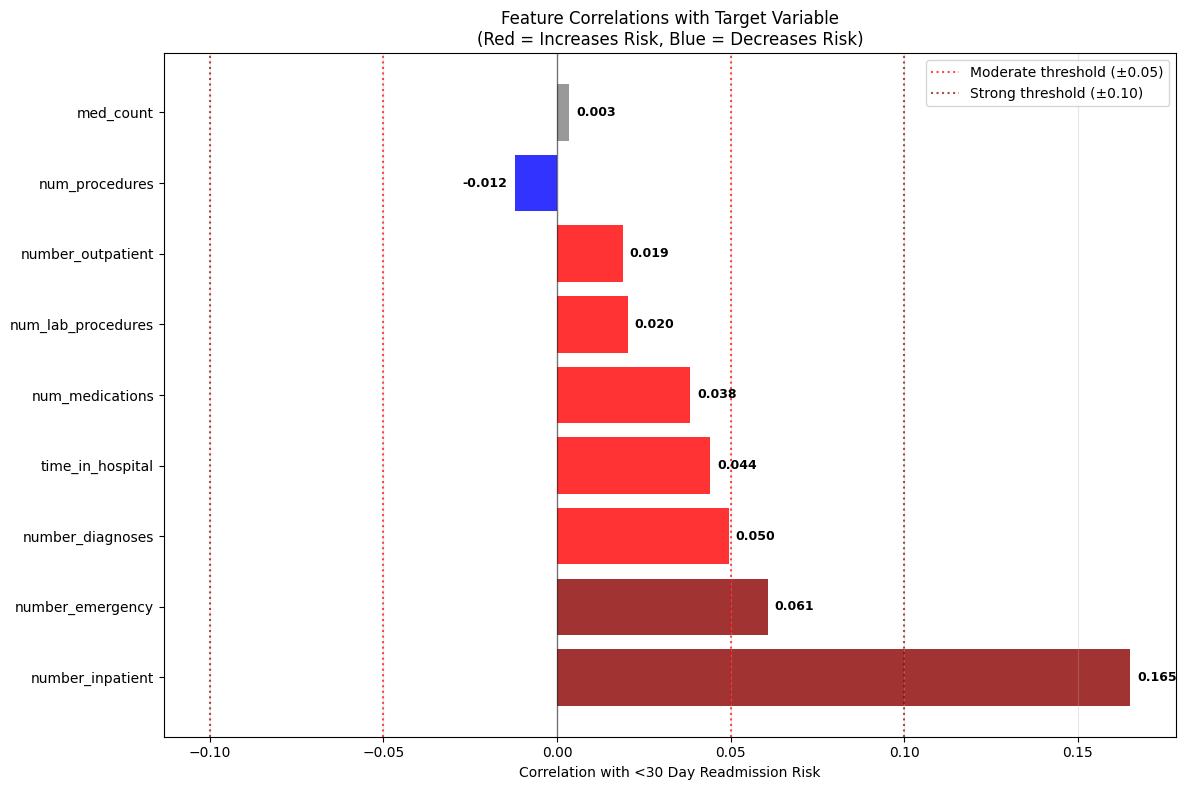


FEATURE SELECTION INSIGHTS:
Strong correlations (>0.1): 1 features
  ['number_inpatient']
Moderate correlations (0.05-0.1): 1 features
  ['number_emergency']
Weak correlations (<0.05): 7 features
  Consider feature engineering or dropping weak features


In [10]:
# =====================================
# 7. CORRELATION ANALYSIS WITH TARGET
# =====================================

def correlation_with_target(df, target_col='readmitted_binary'):
    """Analyze correlations between features and binary target"""
    print("\n" + "="*50)
    print("CORRELATION ANALYSIS WITH TARGET VARIABLE")
    print("="*50)
    
    # Get numerical columns (excluding IDs)
    numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    numerical_cols = [col for col in numerical_cols if 'id' not in col.lower() and 'nbr' not in col.lower()]
    
    # Calculate correlations with binary target
    correlations = []
    for col in numerical_cols:
        if col != target_col:  # Don't correlate target with itself
            corr = df[col].corr(df[target_col])
            if not np.isnan(corr):
                correlations.append((col, corr))
    
    # Sort by absolute correlation
    correlations.sort(key=lambda x: abs(x[1]), reverse=True)
    
    print("Numerical Feature Correlations with <30 Day Readmission:")
    print("(Positive = increases readmission risk, Negative = decreases risk)")
    print()
    
    for feature, corr in correlations:
        if abs(corr) > 0.05:
            strength = "Strong" if abs(corr) > 0.1 else "Moderate"
            direction = "↑" if corr > 0 else "↓"
        else:
            strength = "Weak"
            direction = "↑" if corr > 0 else "↓"
        
        print(f"  {feature:25s}: {corr:7.3f} ({strength}) {direction}")
    
    # Visualization
    if correlations:
        features, corr_values = zip(*correlations)
        
        plt.figure(figsize=(12, 8))
        
        # Create color map based on correlation strength and direction
        colors = []
        for corr in corr_values:
            if corr > 0.05:
                colors.append('darkred')
            elif corr > 0.01:
                colors.append('red')
            elif corr > -0.01:
                colors.append('gray')
            elif corr > -0.05:
                colors.append('blue')
            else:
                colors.append('darkblue')
        
        bars = plt.barh(features, corr_values, color=colors, alpha=0.8)
        plt.xlabel('Correlation with <30 Day Readmission Risk')
        plt.title('Feature Correlations with Target Variable\n(Red = Increases Risk, Blue = Decreases Risk)')
        plt.axvline(x=0, color='black', linestyle='-', alpha=0.5, linewidth=1)
        plt.grid(True, alpha=0.3, axis='x')
        
        # Add correlation value labels
        for bar, value in zip(bars, corr_values):
            x_pos = value + (0.002 if value >= 0 else -0.002)
            plt.text(x_pos, bar.get_y() + bar.get_height()/2,
                    f'{value:.3f}', ha='left' if value >= 0 else 'right',
                    va='center', fontweight='bold', fontsize=9)
        
        # Add significance thresholds
        plt.axvline(x=0.05, color='red', linestyle=':', alpha=0.7, label='Moderate threshold (±0.05)')
        plt.axvline(x=-0.05, color='red', linestyle=':', alpha=0.7)
        plt.axvline(x=0.1, color='darkred', linestyle=':', alpha=0.7, label='Strong threshold (±0.10)')
        plt.axvline(x=-0.1, color='darkred', linestyle=':', alpha=0.7)
        
        plt.legend()
        plt.tight_layout()
        plt.show()
    
    # Feature importance insights
    print(f"\nFEATURE SELECTION INSIGHTS:")
    strong_features = [f for f, c in correlations if abs(c) > 0.1]
    moderate_features = [f for f, c in correlations if 0.05 < abs(c) <= 0.1]
    weak_features = [f for f, c in correlations if abs(c) <= 0.05]
    
    print(f"Strong correlations (>0.1): {len(strong_features)} features")
    if strong_features:
        print(f"  {strong_features}")
    
    print(f"Moderate correlations (0.05-0.1): {len(moderate_features)} features")
    if moderate_features:
        print(f"  {moderate_features}")
    
    print(f"Weak correlations (<0.05): {len(weak_features)} features")
    print("  Consider feature engineering or dropping weak features")
    
    return correlations

# Run correlation analysis
if df is not None:
    feature_correlations = correlation_with_target(df)


DUPLICATE ANALYSIS
Exact duplicate rows: 0
Duplicate patient numbers: 30,248
Unique patients: 71,518
Total encounters: 101,766
Average encounters per patient: 1.42
Patients with multiple encounters: 16,773
Patients with single encounter: 54,745


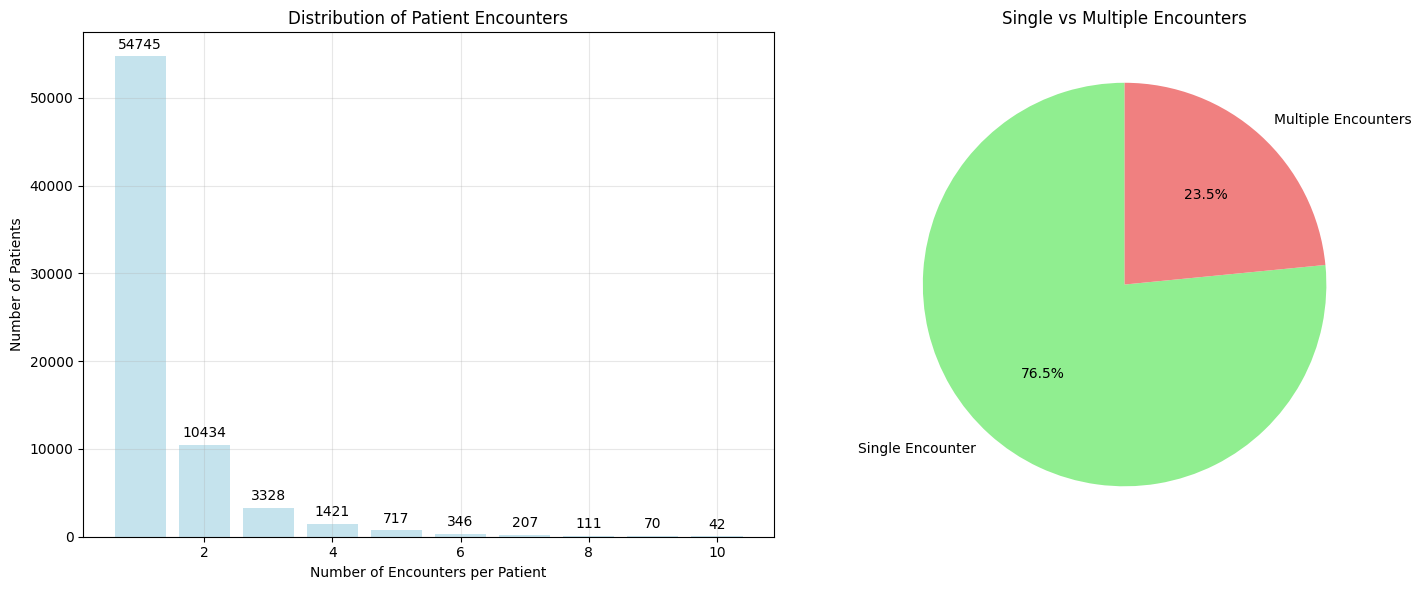


DATA QUALITY SUMMARY:
  23.5% of patients have multiple encounters
  No exact duplicate rows found


In [11]:
# =====================================
# 8. DUPLICATE ANALYSIS
# =====================================

def analyze_duplicates(df):
    """Analyze duplicate records for data quality insights"""
    print("\n" + "="*50)
    print("DUPLICATE ANALYSIS")
    print("="*50)
    
    # Check for exact duplicates
    duplicate_rows = df.duplicated().sum()
    print(f"Exact duplicate rows: {duplicate_rows:,}")
    
    # Check for duplicate patient encounters
    if 'patient_nbr' in df.columns:
        duplicate_patients = df['patient_nbr'].duplicated().sum()
        unique_patients = df['patient_nbr'].nunique()
        
        print(f"Duplicate patient numbers: {duplicate_patients:,}")
        print(f"Unique patients: {unique_patients:,}")
        print(f"Total encounters: {len(df):,}")
        print(f"Average encounters per patient: {len(df)/unique_patients:.2f}")
        
        # Patients with multiple encounters
        patient_encounters = df['patient_nbr'].value_counts()
        multiple_encounters = (patient_encounters > 1).sum()
        
        print(f"Patients with multiple encounters: {multiple_encounters:,}")
        print(f"Patients with single encounter: {unique_patients - multiple_encounters:,}")
        
        # Visualization
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))
        
        # Distribution of encounters per patient
        encounter_dist = patient_encounters.value_counts().sort_index()
        encounter_dist_limited = encounter_dist.head(10)  # Show up to 10 encounters
        
        axes[0].bar(encounter_dist_limited.index, encounter_dist_limited.values, 
                   color='lightblue', alpha=0.7)
        axes[0].set_xlabel('Number of Encounters per Patient')
        axes[0].set_ylabel('Number of Patients')
        axes[0].set_title('Distribution of Patient Encounters')
        axes[0].grid(True, alpha=0.3)
        
        # Add value labels on bars
        for i, v in enumerate(encounter_dist_limited.values):
            axes[0].text(encounter_dist_limited.index[i], v + max(encounter_dist_limited.values)*0.01, 
                        str(v), ha='center', va='bottom')
        
        # Single vs Multiple encounters
        single_vs_multiple = [unique_patients - multiple_encounters, multiple_encounters]
        labels = ['Single Encounter', 'Multiple Encounters']
        
        axes[1].pie(single_vs_multiple, labels=labels, autopct='%1.1f%%', 
                   colors=['lightgreen', 'lightcoral'], startangle=90)
        axes[1].set_title('Single vs Multiple Encounters')
        
        plt.tight_layout()
        plt.show()
        
        # Data quality summary
        print(f"\nDATA QUALITY SUMMARY:")
        if multiple_encounters > 0:
            multiple_pct = (multiple_encounters / unique_patients) * 100
            print(f"  {multiple_pct:.1f}% of patients have multiple encounters")
        
        if duplicate_rows > 0:
            print(f"  {duplicate_rows:,} exact duplicate rows found")
        else:
            print(f"  No exact duplicate rows found")
    
    return duplicate_rows, unique_patients if 'patient_nbr' in df.columns else None

# Run duplicate analysis
if df is not None:
    duplicates, unique_patients = analyze_duplicates(df)

Medication Usage and Readmission Rate Analysis:
Note: Filter of >=100 patients recommended for statistical reliability
(Small sample sizes may show misleading differences)

metformin: 19,988 patients, difference: -1.8%
repaglinide: 1,539 patients, difference: +2.2%
nateglinide: 703 patients, difference: +0.2%
chlorpropamide: 86 patients, difference: -5.4%
glimepiride: 5,191 patients, difference: -1.0%
acetohexamide: 1 patients, difference: -11.2%
glipizide: 12,686 patients, difference: +0.3%
glyburide: 10,650 patients, difference: -0.6%
tolbutamide: 23 patients, difference: -6.8%
pioglitazone: 7,328 patients, difference: -0.6%
rosiglitazone: 6,365 patients, difference: -0.8%
acarbose: 308 patients, difference: -2.1%
miglitol: 38 patients, difference: -0.6%
troglitazone: 3 patients, difference: -11.2%
tolazamide: 39 patients, difference: -3.5%
insulin: 54,383 patients, difference: +2.1%


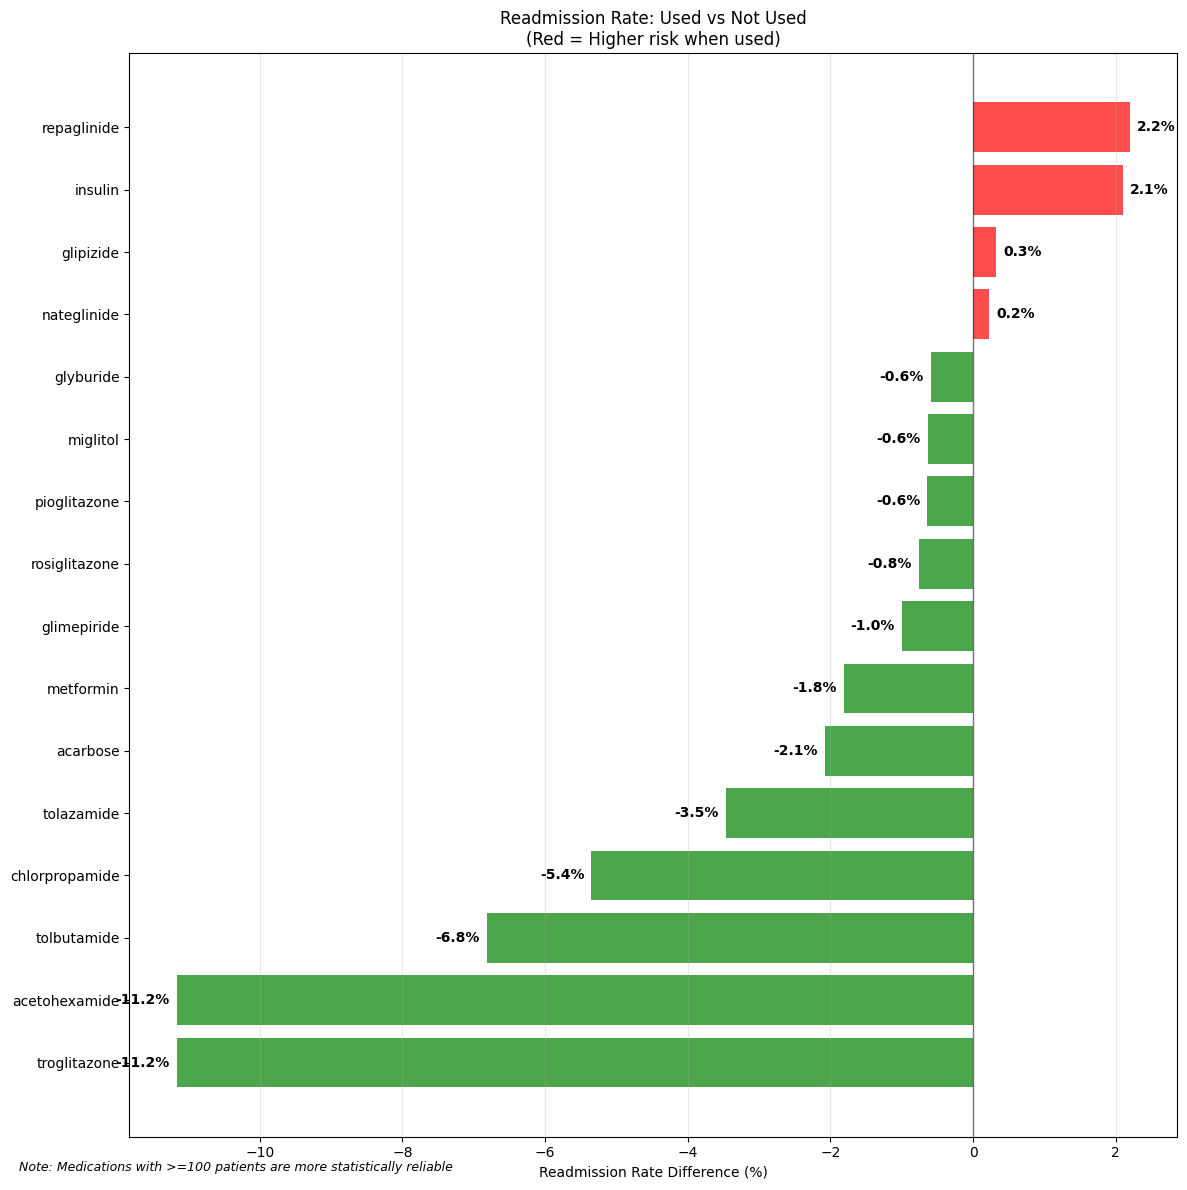


Summary: 10 medications with >=100 patients
         6 medications with <100 patients


In [16]:
# =====================================
# MEDICATION READMISSION RATE DIFFERENCE CHART
# =====================================

def create_medication_readmission_chart(df, target_col='readmitted_binary'):
    """Create medication readmission rate difference chart"""
    
    # Medication columns
    medication_cols = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
                       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide',
                       'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
                       'miglitol', 'troglitazone', 'tolazamide', 'examide',
                       'citoglipton', 'insulin']
    
    # Calculate readmission rate differences for ALL medications
    med_differences = []
    
    print("Medication Usage and Readmission Rate Analysis:")
    print("Note: Filter of >=100 patients recommended for statistical reliability")
    print("(Small sample sizes may show misleading differences)\n")
    
    for med in medication_cols:
        if med in df.columns:
            # Calculate usage for all medications
            used_count = (df[med] != 'No').sum()
            
            if used_count > 0:  # Only need at least 1 patient
                # Readmission rates
                med_used_rate = df[df[med] != 'No'][target_col].mean() * 100
                med_not_used_rate = df[df[med] == 'No'][target_col].mean() * 100
                difference = med_used_rate - med_not_used_rate
                
                # Track reliability status
                reliable = used_count >= 100
                
                med_differences.append((med, difference, used_count, reliable))
                print(f"{med}: {used_count:,} patients, difference: {difference:+.1f}%")
    
    # Sort by difference
    med_differences.sort(key=lambda x: x[1])
    
    # Prepare data for plotting
    medications, differences, counts, reliability = zip(*med_differences)
    
    # Create colors: red for positive (higher risk), green for negative (lower risk)
    colors = ['green' if diff < 0 else 'red' for diff in differences]
    
    # Create the chart
    plt.figure(figsize=(12, 12))
    bars = plt.barh(medications, differences, color=colors, alpha=0.7)
    
    # Formatting
    plt.xlabel('Readmission Rate Difference (%)')
    plt.title('Readmission Rate: Used vs Not Used\n(Red = Higher risk when used)')
    plt.axvline(x=0, color='black', linestyle='-', alpha=0.5, linewidth=1)
    plt.grid(True, alpha=0.3, axis='x')
    
    # Add value labels on bars
    for bar, diff, count, reliable in zip(bars, differences, counts, reliability):
        x_pos = diff + (0.1 if diff >= 0 else -0.1)
        plt.text(x_pos, bar.get_y() + bar.get_height()/2,
                f'{diff:.1f}%', ha='left' if diff >= 0 else 'right',
                va='center', fontweight='bold', fontsize=10)
    
    # Add note about statistical reliability
    plt.figtext(0.02, 0.02, "Note: Medications with >=100 patients are more statistically reliable", 
                fontsize=9, style='italic')
    
    plt.tight_layout()
    plt.show()
    
    reliable_count = sum(1 for r in reliability if r)
    unreliable_count = len(reliability) - reliable_count
    
    print(f"\nSummary: {reliable_count} medications with >=100 patients")
    print(f"         {unreliable_count} medications with <100 patients")

# Run the chart
if df is not None:
    create_medication_readmission_chart(df)